# Instance Segmentation

## Models

### Mask R-CNN
Pre-trained models from the [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md).

- [R50-FPN 3x](https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml)
- [X101-FPN 3x](https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml)
- [X152](https://github.com/facebookresearch/detectron2/blob/main/configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml)
- [R50-FPN, Cityscapes](https://github.com/facebookresearch/detectron2/blob/main/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml)

### Yolact
Pre-trained from [YolactEdge GitHub](https://github.com/haotian-liu/yolact_edge). YolactEdge models use [TensorRT](https://developer.nvidia.com/tensorrt).

- [YOLACT R-50-FPN]()
- [YOLACT R-101-FPN]()
- [YolactEdge R-50-FPN]()
- [YolactEdge R-101-FPN]()



## Inference Time and AP

Inference time was evaluated with the `benchmark_fps.py` script on 642 frames of the A9 dataset. An Ubuntu 20.04 server with a NVIDIA GeForce RTX 3090 and AMD EPYC 7282 16-Core Processor was used. The measured time includes transfering frames to GPU because that would also be relevant for my real use-case. 

All models are pre-trained on [COCO](https://cocodataset.org), except the last one on [Cityscapes](https://www.cityscapes-dataset.com/)*. The AP scores on the respective datasets are provided by the authors.

| Model | Backbone | Mask (m)AP | FPS |
| --- | --- | --- | --- |
| Mask R-CNN | R50-FPN 3x | 37.2 | 14.5 |
| Mask R-CNN | X101-FPN 3x | 39.5 | 9.2 |
| Mask R-CNN | X152 | 44.0 | 4.5 |
| YOLACT | R-50-FPN | 28.2 | 30.2 |
| YOLACT | R-101-FPN | 29.8 | 22.6 |
| YolactEdge | R-50-FPN | 27.0 | 59.7 |
| YolactEdge | R-101-FPN | 29.5 | 59.0 |
| Mask R-CNN | R50-FPN, Cityscapes | 36.5* | 11.6 |



## Qualitative Results

In [1]:
# Allows import from parent directory.
import sys; sys.path.append('..')

import os

import matplotlib.pyplot as plt
import plotly.express as px
import src.visualization_utils as viz
from mpl_toolkits.axes_grid1 import ImageGrid
from src.loaders import DetectionsLoader, FrameLoader

In [2]:
# A9 dataset frames
frame_loader = FrameLoader('../data/r0_a9_dataset/images')

# Create detections loeader for every model.
detections_dir_path = '../data/detections/r0_a9_dataset'
detections_loaders = {
    name: DetectionsLoader(os.path.join(detections_dir_path, name))
    for name in sorted(os.listdir(detections_dir_path))
}

valid_labels = {'coco': [2, 5, 7], 'cityscapes': [2, 3]}
score_threshold = 0.7

colors = px.colors.qualitative.Plotly

output_dir = 'output/instance_segmentation'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Create frames with overlayed masks for every model.

index = 364
frame = frame_loader.load_item(index)
detections = {}
for key, loader in detections_loaders.items():
    ds = loader.load_item(index)
    ls = valid_labels[key.split('_')[0]]
    ds = [d for d in ds if d.score > score_threshold and d.label in ls]
    detections[key] = ds

overlayed_frames = {
    key: viz.overlay_colored_boxes(
        viz.overlay_colored_masks(frame, ds, colors), ds, colors, 4
    )
    for key, ds in detections.items()
}

# Save frames.
for key, img in overlayed_frames.items():
    plt.imsave(os.path.join(output_dir, f'{key}.png'), img)


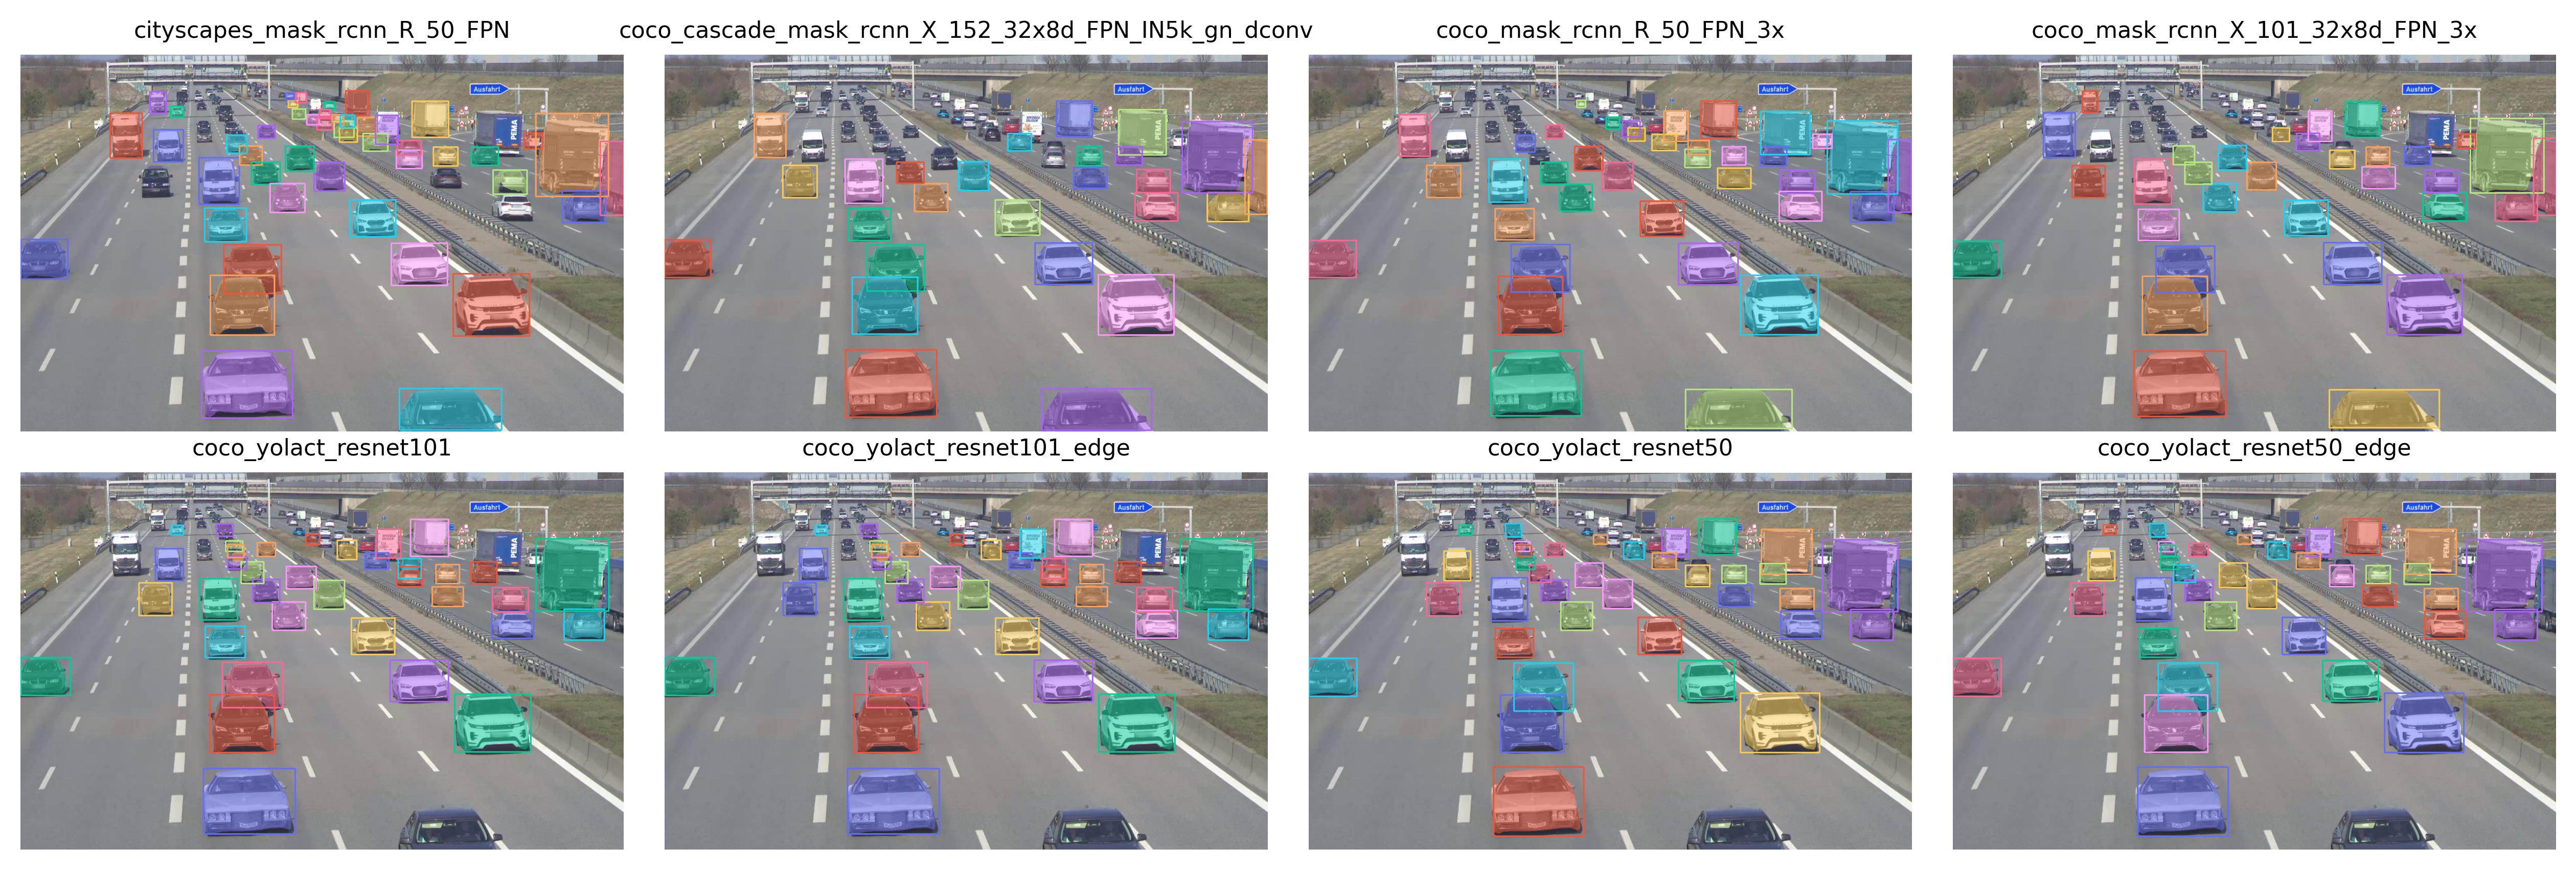

In [4]:
# Show frames with overlayed masks.
fig = plt.figure(figsize=(16, 8), dpi=400)
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.2)
for ax, (key, img) in zip(grid, overlayed_frames.items()):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(key, {'fontsize': 8})
plt.show()

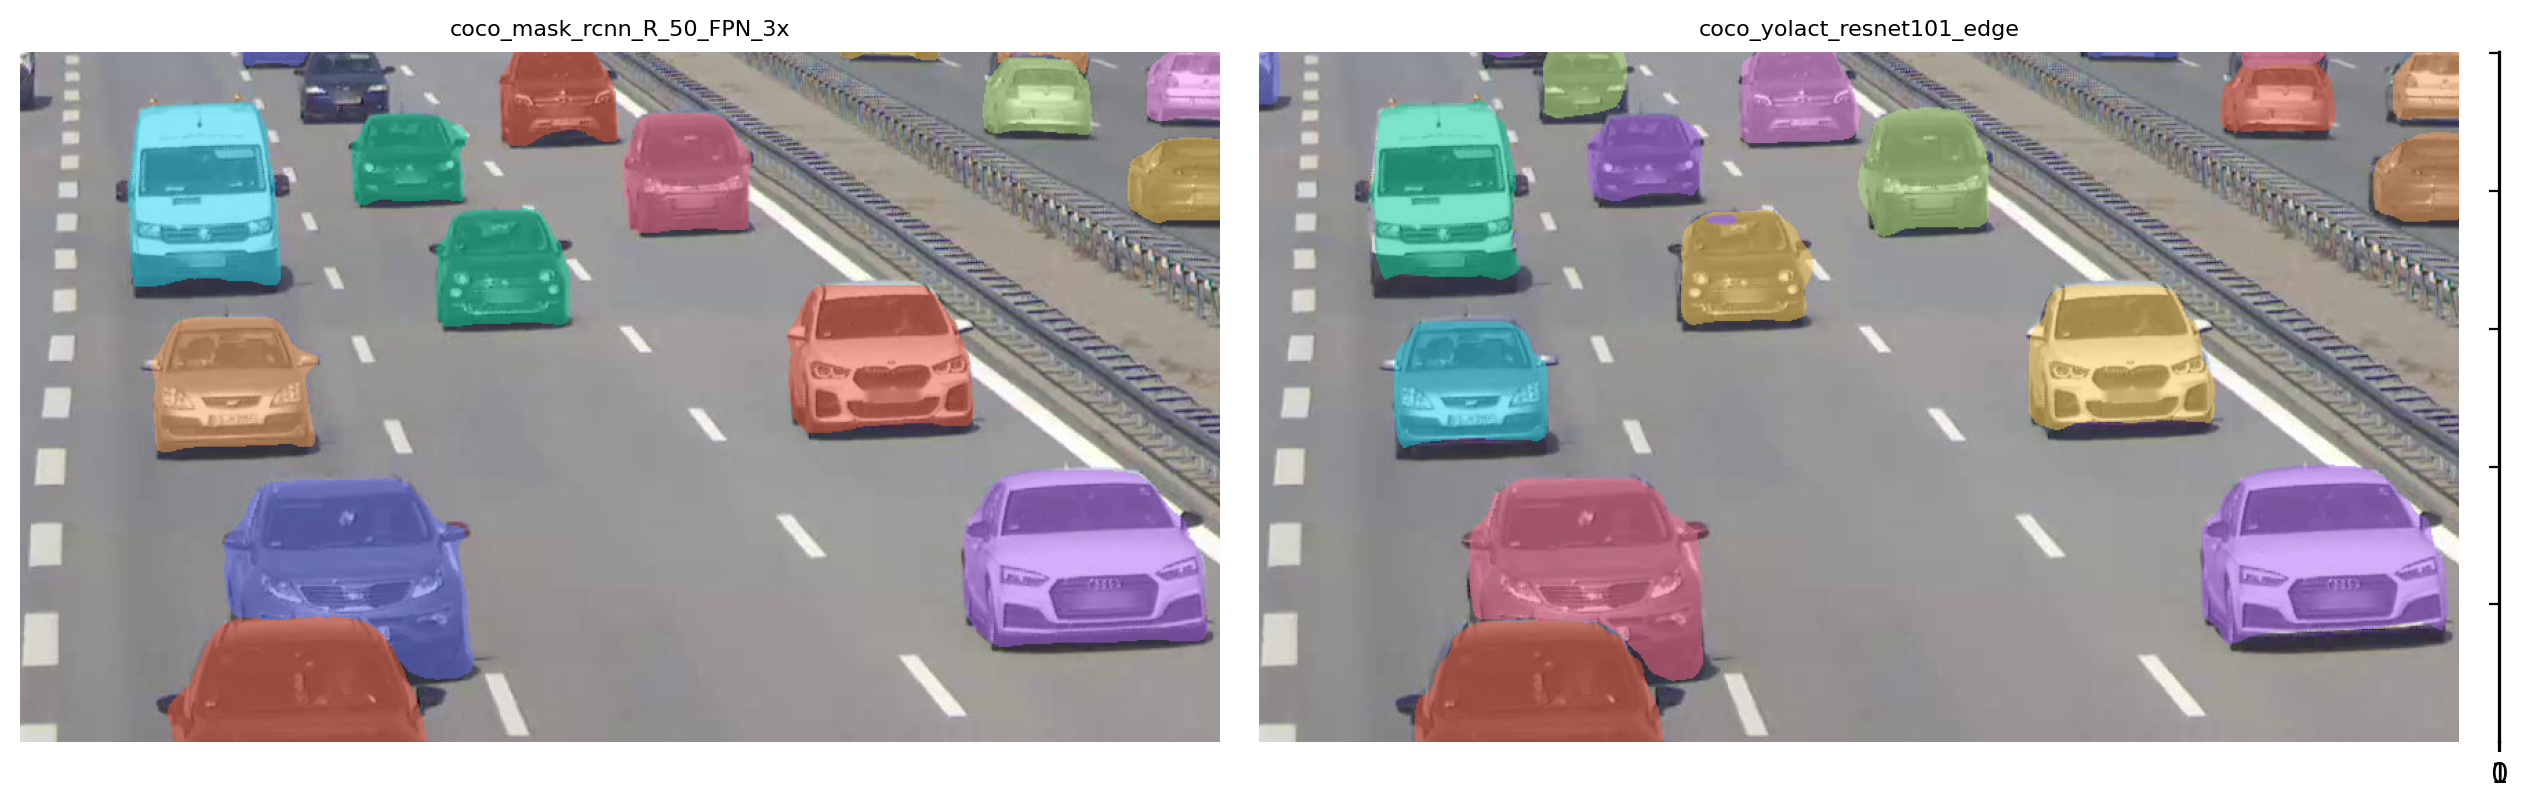

In [5]:
# Show differences between Mask R-CNN and YolactEdge
fig = plt.figure(figsize=(16, 8), dpi=200)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.2)
names = ('coco_mask_rcnn_R_50_FPN_3x', 'coco_yolact_resnet101_edge')
imgs = [viz.overlay_colored_masks(frame, detections[name], colors) for name in names]
imgs = [img[300:-400, 500:-550] for img in imgs]
for ax, img, name in zip(grid, imgs, names):
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(name, {'fontsize': 8})
plt.show()

# Save frames.
for name, img in zip(names, imgs):
    plt.imsave(os.path.join(output_dir, f'cropped_{name}.png'), img)


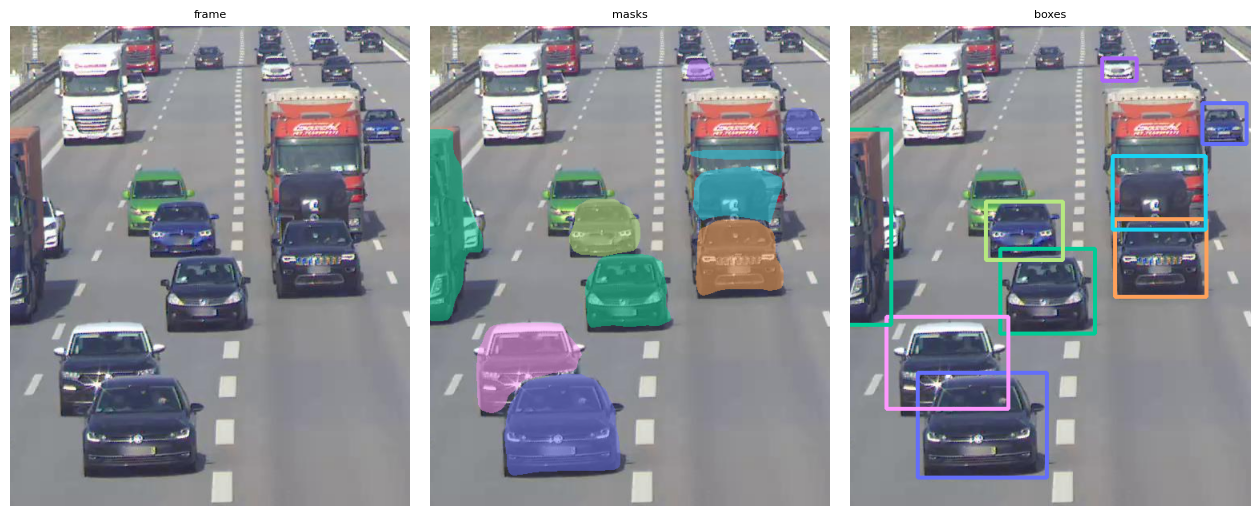

In [6]:
# Show frame, masks, and boxes for partially occluded vehicles.
index = 298
frame = frame_loader.load_item(index)
ds = detections_loaders['coco_yolact_resnet101_edge'].load_item(index)
ds = [d for d in ds if d.score > score_threshold and d.label in valid_labels['coco']]

mask_img = viz.overlay_colored_masks(frame, ds, colors)
box_img = viz.overlay_colored_boxes(frame, ds, colors, 4)
imgs = (frame, mask_img, box_img)
imgs = [img[150:750, 250:750] for img in imgs]
names = ['frame', 'masks', 'boxes']

fig = plt.figure(figsize=(16, 8), dpi=100)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.2)
for ax, img, name in zip(grid, imgs, names):
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(name, {'fontsize': 8})
plt.show()

# Save frames.
for name, img in zip(names, imgs):
    plt.imsave(os.path.join(output_dir, f'occluded_{name}.png'), img)
